In [1]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np 
import pickle 
import time


In [53]:
# load model 

# Choice 1: flexible model
# model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/flexible_models_best_FP/r0_r2_FP_trial_2/")
# checkpoint_path = model_path / "checkpoints/epoch=42-all_inputs.ckpt"

# Choice  2: all-three nmr model
model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/entropy_radius_exps_all_info/R0_to_R4_all_info_trial_1")
checkpoint_path = model_path / "checkpoints/epoch=22-step=11408.ckpt"



hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)
print(int(hparams['FP_choice'].split("_")[-1][1:]))
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
4


In [54]:

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [55]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

In [56]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [57]:
# len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

In [58]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [59]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename)

Chemspider_Pyristriatin A
COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
10022.pt


In [60]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C',
 'Chemspider_Pyristriatin A')

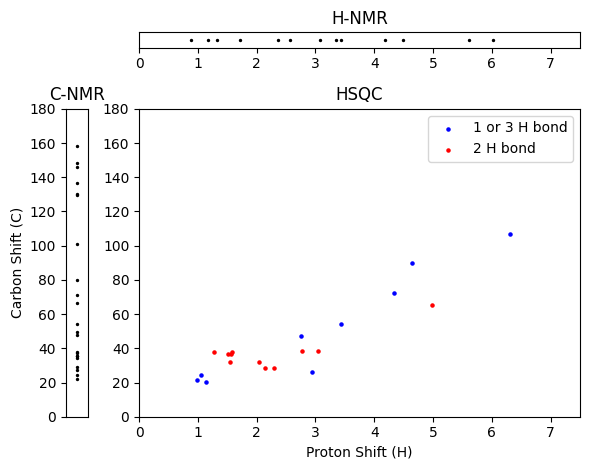

In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_NMR(hsqc, c_tensor, h_tensor):
    # print(hsqc, c_tensor, h_tensor)
    # Create a 2x2 grid for subplots
    fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

    # Create subplots in different locations and sizes
    ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
    if hsqc is not None:
        pos = hsqc[hsqc[:,2]>0]
        neg = hsqc[hsqc[:,2]<0]
        ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
        ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
        # print("scatter!!")
        # print(pos, neg)
    ax1.set_title("HSQC")
    ax1.set_xlabel('Proton Shift (H)')  # X-axis label
    ax1.set_xlim([0, 7.5])
    ax1.set_ylim([0, 180])
    ax1.legend()


    ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
    if c_tensor is not None:
        ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
    ax2.set_ylim([0, 180])
    ax2.set_title("C-NMR")
    ax2.set_ylabel('Carbon Shift (C)')
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
    if h_tensor is not None:
        ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
    ax3.set_xlim([0, 7.5])
    ax3.set_title("H-NMR")
    ax3.set_yticks([])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_NMR(hsqc, c_tensor, h_tensor)

In [62]:
import torch.nn.functional as F
import heapq

def retrieve_top_k_by_dir(dir, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()
    results = []
    for  ranker_f in sorted(os.listdir(dir), key=lambda x:int(x.split("_")[1].split(".")[0])):
    # for num_ranker_data, ranker_f in [(54,"FP_54.pt")]:
        # print(ranker_f)
        num_ranker_data = int(ranker_f.split("_")[1].split(".")[0])
        data = torch.load(os.path.join(dir, ranker_f)).to("cuda")
        query_products = (data @ query)
        values, indices = torch.topk(query_products,k=k)
        if len(results) == 0:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappush(results, (value, real_idx, data[idx].nonzero()))
        else:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappushpop(results, (value, real_idx, data[idx].nonzero()))    
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret

def retrieve_top_k_by_rankingset(data, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()

    results = []
    query_products = (data @ query)
    values, indices = torch.topk(query_products,k=k)
    
    for value, idx in zip(values, indices):
        results.append((value, idx, data[idx].nonzero()))
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret
        

In [63]:
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names.pkl', 'rb'))
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_only_2d_dataset.pkl', 'rb'))
smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_remove_stereoChemistry.pkl', 'rb'))

# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/test_smiles_and_names.pkl', 'rb'))

In [64]:
# rankingset_path = '/root/MorganFP_prediction/inference_data/max_radius_2_only_2d_False_together_only_2d_dataset/FP.pt'
rankingset_path = '/root/MorganFP_prediction/inference_data/max_radius_2_only_2d_False_together_no_stereoChemistry_dataset/FP.pt'

rankingset_data = torch.load(rankingset_path).to("cuda")

smiles_to_NMR_path = pickle.load(open('/root/MorganFP_prediction/inference_data/SMILES_chemical_to_NMR_paths.pkl','rb'))

In [65]:
smiles_to_NMR_path['COC1OC(CO)C(O)C(O)C1O']

('/workspace/SMILES_dataset/test/HSQC/10002.pt',
 '/workspace/SMILES_dataset/test/oneD_NMR/10002.pt')

In [66]:
def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor

# unpack_inputs(inputs)

In [67]:
'''
show some examples from my dataset to check sanity
'''

# '''for a single model, show top-5'''
# # model.to("cuda")
# for  which_compound in range(0, 2):  
    
#     print(f"######### compound number: {which_compound}##############################################################")
    
#     for idx, batch in enumerate(loader_all_inputs):
#         if idx < which_compound:
#             continue
#         inputs, (smiles_chemical_name) = batch
#         # print(inputs.shape, inputs)
#         # print(inputs, smiles_chemical_name)
        
#         # batch[0] = batch[0].to("cuda")
#         hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
#         inputs = inputs.to("cuda")
#         pred = model(inputs)
#         pred=torch.sigmoid(pred) # sigmoid
#         pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
#         # print(pred_FP.nonzero().squeeze().tolist())
#         break
#     # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
#     # print(inputs)
    
#     print("Ground Truth NMR")
#     plot_NMR(hsqc, c_tensor, h_tensor)
    
#     topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=2)
#     # ground truth
#     smiles, names, path = zip(*smiles_chemical_name)
#     mol = Chem.MolFromSmiles(smiles[0])
#     print(f"Chemical name {names[0]}")
#     print(f"Ground truth smiles {smiles[0]}")
#     print(f"Ground truth NMR path {path[0]}")
#     img = Draw.MolToImage(mol)
#     img.show()
    
    
#     i=0
#     for value, (smile, name, _, _), retrieved_FP in topk:
#         print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
#         mol = Chem.MolFromSmiles(smile)
#         # print("retrived FP", retrieved_FP.squeeze().tolist())
#         hsqc_path, oned_path = smiles_to_NMR_path[smile]
#         #check is path file exists
#         hsqc, c_tensor, h_tensor = None, None, None
#         print("retrieved path: ",oned_path)
#         if os.path.exists(hsqc_path):
#             hsqc = torch.load(hsqc_path)
#         if os.path.exists(oned_path):
#             c_tensor, h_tensor = torch.load(oned_path)
#         # plot_NMR(hsqc, c_tensor, h_tensor)
#         print(f"SMILES: {smile}")
#         print(f"Name {name}")
#         img = Draw.MolToImage(mol)
#         img.show()
#         i+=1
        



'\nshow some examples from my dataset to check sanity\n'

In [68]:
def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

 

In [69]:
# !!!
def compute_cos_sim(fp1, fp2):
    return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()

"""
Nice !
Now we can play with unkown molecule
"""
hsqc_mode = None
'''for a single model, show top-5'''
def show_topK(inputs, k=5, mode = hsqc_mode, ground_truth_FP=None):
    print("_________________________________________________________")

    
    inputs = inputs.unsqueeze(0).to("cuda")
    pred = model(inputs)
    pred = torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    if ground_truth_FP is not None:
        print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()))
        print("\n\n")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k)
       
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, retrival cosine similarity to prediction: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        if ground_truth_FP is not None:
            retrieved_FP_6144 = torch.zeros(6144)
            retrieved_FP_6144[retrieved_FP.cpu()] = 1
            print("Retrival's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, retrieved_FP_6144))
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        # print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
            
        if hsqc is not None:
            if mode == "no_sign":
                hsqc = torch.abs(hsqc)
            elif mode == "flip_sign":
                hsqc[:,2] = -hsqc[:,2]
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [70]:
def build_input(compound_dir, mode = hsqc_mode, include_hsqc = True, include_c_nmr = True, include_h_nmr = True):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    input_NMRs = []
    if include_hsqc:
        input_NMRs+= [get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end")]
    if include_c_nmr:
        input_NMRs+= [get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end")]
    if include_h_nmr:
        input_NMRs+= [get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end")]
    inputs = torch.vstack(input_NMRs)   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    # plot_NMR(hsqc, c_tensor[:,0], h_tensor[:,0])
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])

In [71]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

In [72]:
(newCompoundA_FP.dtype)

torch.float32

In [73]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1


____________________________retival #1, cosine similarity: 0.2283148169517517_____________________________
retrived FP [5, 7, 11, 12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 37, 38, 41, 42, 43, 51, 52, 53, 54, 55, 56, 57, 66, 69, 74, 75, 76, 77, 78, 84, 85, 98, 107, 108, 109, 110, 111, 112, 134, 135, 136, 137, 138, 139, 144, 150, 152, 158, 166, 168, 172, 185, 191, 192, 193, 195, 196, 197, 224, 226, 230, 231, 232, 243, 251, 254, 287, 294, 307, 370, 371, 373, 384, 396, 439, 450, 454, 458, 470, 472, 477, 517, 527, 537, 548, 590, 591, 592, 593, 594, 660, 661, 662, 716, 735, 806, 829, 912, 926, 959, 996, 1012, 1066, 1069, 1086, 1183, 1349, 1365, 1466, 1594, 2130, 2843, 2898, 3388, 4975, 5067, 5127]
SMILES: C=C1C(=O)OC2C=C(C)CCC=C(C(=O)OC)C(O)C(OC(=O)C(C)C)C12
Name methyl 5-hydroxy-10-methyl-3-methylidene-4-[(2-methylpropanoyl)oxy]-2-oxo-3ah,4h,5h,8h,9h,11ah-cyclodeca[b]furan-6-carboxylate


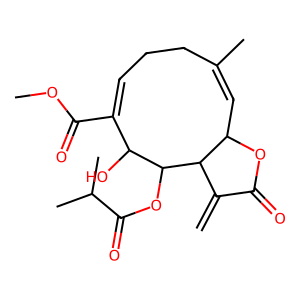

____________________________retival #2, cosine similarity: 0.22547423839569092_____________________________
retrived FP [0, 1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 79, 80, 81, 86, 88, 93, 94, 98, 99, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 115, 118, 119, 120, 121, 122, 124, 126, 127, 128, 129, 131, 133, 135, 136, 137, 138, 139, 141, 143, 148, 151, 152, 155, 156, 157, 158, 159, 160, 162, 167, 174, 177, 191, 192, 193, 195, 196, 204, 218, 224, 226, 228, 230, 231, 232, 238, 245, 253, 258, 261, 263, 267, 273, 281, 287, 289, 293, 296, 298, 307, 324, 327, 335, 337, 354, 356, 359, 360, 363, 370, 371, 373, 383, 423, 435, 442, 461, 474, 502, 504, 512, 526, 555, 565, 568, 590, 591, 592, 593, 594, 601, 623, 632, 648, 651, 658, 660, 661, 662, 673, 679, 693, 935, 976, 1088, 1133, 1166, 1352, 1379, 139

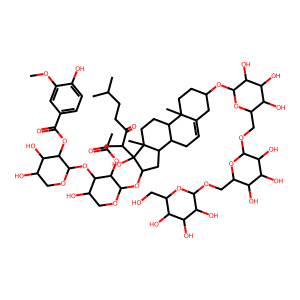

In [74]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)

In [75]:
deepSAT_sintokamide_B_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES("CCC(=O)N[C@H](C[C@H](C)C(Cl)(Cl)Cl)C(=O)N1[C@H](C(=CC1=O)OC)C[C@H](C)C(Cl)(Cl)Cl")
compute_cos_sim(deepSAT_sintokamide_B_FP, Kavaratamide_A_FP)

tensor(0.5642791390)




Kavaratamide A


_________________________________________________________
cuda:0 cuda:0
Prediction's cosine similarity to ground truth:  tensor(0.5435177684)



____________________________retival #1, retrival cosine similarity to prediction: 0.25687724351882935_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.2254742235)
SMILES: COc1cc(C(=O)OC2C(OC3C(O)COC(OC4CC5C6CC=C7CC(OC8OC(COC9OC(COC%10OC(CO)C(O)C(O)C%10O)C(O)C(O)C9O)C(O)C(O)C8O)CCC7(C)C6CCC5(C)C4(O)C(C)C(=O)CCC(C)C)C3OC(C)=O)OCC(O)C2O)ccc1O
Name 3Beta-[(O-Beta-D-Glucopyranosyl-(1->4)-O-Beta-D-Glucopyranosyl-(1->6)-Beta-D-Glucopyranosyl)Oxy)]-17Alpha-Hydroxy-16Beta-[(O-(2-O-4-Hydroxy-3-Methoxybenzoyl-Beta-D-Xylopyranosyl)-(1->3)-2-O-Acetyl-Alpha-L-Arabinopyranosyl)Oxy]Cholest-5-En-22-On


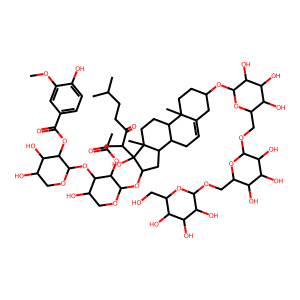

____________________________retival #2, retrival cosine similarity to prediction: 0.2450360655784607_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.1918228120)
SMILES: COc1cc(C(O)C(CO)Oc2ccc(C=CC(=O)OC3CC(C)(O)C4C(OC5OC(CO)C(O)C(O)C5O)OC=CC34)cc2OC)ccc1O
Name 7-hydroxy-7-methyl-1-{[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-1h,4ah,5h,6h,7ah-cyclopenta[c]pyran-5-yl 3-(4-{[1,3-dihydroxy-1-(4-hydroxy-3-methoxyphenyl)propan-2-yl]oxy}-3-methoxyphenyl)prop-2-enoate


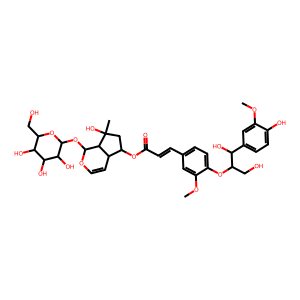

____________________________retival #3, retrival cosine similarity to prediction: 0.24438880383968353_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.1902597547)
SMILES: COc1cc(C=CC(=O)OCC2OC(OC3CC(C)(C)C(C=CC(C)O)=C(C)C3O)C(O)C(O)C2O)ccc1O
Name crotonionoside G


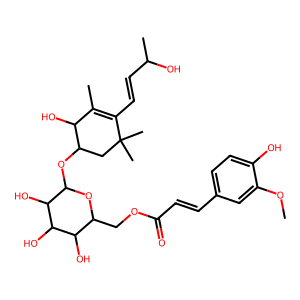

____________________________retival #4, retrival cosine similarity to prediction: 0.24207265675067902_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.2079545856)
SMILES: COc1ccc(C(=O)OC2C(O)COC(OC3C(O)COC(OC4CC5C6CC=C7CC(OC8OC(COC9OC(COC%10OC(CO)C(O)C(O)C%10O)C(O)C(O)C9O)C(O)C(O)C8O)CCC7(C)C6CCC5(C)C4(O)C(C)C(=O)CCC(C)C)C3OC(C)=O)C2O)cc1OC
Name 3Beta-[(O-Beta-D-Glucopyranosyl-(1->4)-O-Beta-D-Glucopyranosyl-(1->6)-Beta-Dglucopyranosyl)Oxy)]-17Alpha-Hydroxy-16Beta-[(O-(3-O-3,4-Dimethoxybenzoyl-Beta-D-Xylopyranosyl)-(1->3)-2-O-Acetyl-Alpha-L-Arabinopyranosyl)Oxy]Cholest-5-En-22-One


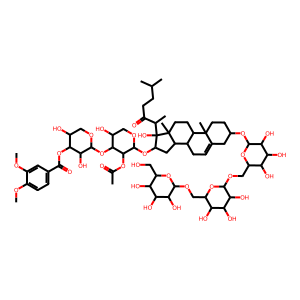

____________________________retival #5, retrival cosine similarity to prediction: 0.2394147664308548_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.2079545856)
SMILES: COc1cc(C(=O)OC2C(OC3C(O)COC(OC4CC5C6CC=C7CC(OC8OC(COC9OC(CO)C(O)C(O)C9O)C(O)C(O)C8O)CCC7(C)C6CCC5(C)C4(O)C(C)C(=O)CCC(C)C)C3OC(C)=O)OCC(O)C2O)cc(OC)c1OC
Name 3Beta-[(O-Beta-D-Glucopyranosyl-(1->6)-Beta-D-Glucopyranosyl)Oxy)]-17Alpha-Hydroxy-16Beta-[(O-(2-O-3,4,5-Trimethoxybenzoyl-Beta-D-Xylopyranosyl)-(1->3)-2-O-Acetyl-Alpha-L-Arabinopyranosyl)Oxy]Cholest-5-En-22-One


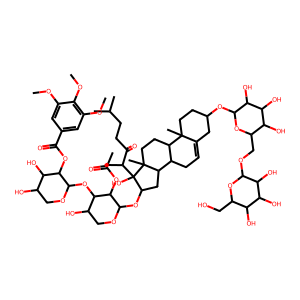

In [78]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode,
                    #  include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5, mode=mode, ground_truth_FP = Kavaratamide_A_FP)
# show_topK(inputs, k=1)

In [77]:
aaaaa

NameError: name 'aaaaa' is not defined




new_compound_A


_________________________________________________________
cuda:0 cuda:0
Prediction's cosine similarity to ground truth:  tensor(0.6478977799)



____________________________retival #1, retrival cosine similarity to prediction: 0.7150909900665283_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6778365970)
SMILES: CCC(C)C1C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC(C)C(NC(=O)C(CC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(=O)NC(CC(C)C)C(=O)NC2CCC(OC)N1C2=O
Name Micropeptin KB992


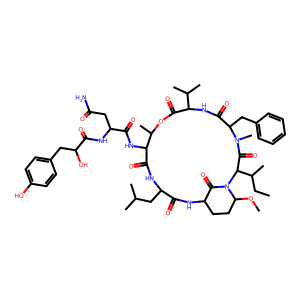

____________________________retival #2, retrival cosine similarity to prediction: 0.714163064956665_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6790155768)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name micropeptin MZ859


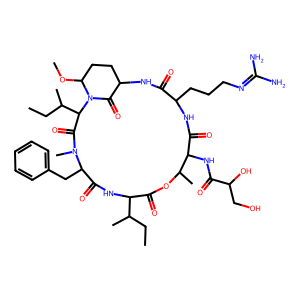

____________________________retival #3, retrival cosine similarity to prediction: 0.7128043174743652_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6831446886)
SMILES: CCCC(=O)NC(Cc1ccc(O)cc1)C(=O)NC(CCC(=O)NC1C(=O)NC(CCCN=C(N)N)C(=O)NC2CCC(O)N(C2=O)C(C(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)CC)C(=O)OC1C)C(=O)OC
Name Micropeptin 1120


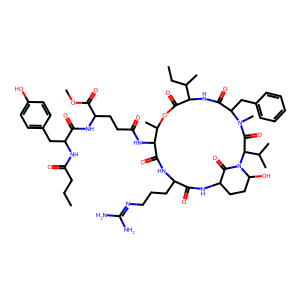

In [ ]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
inputs = build_input(compound_dir)
show_topK(inputs, k=3, ground_truth_FP=newCompoundA_FP)




new_compound_B1




_________________________________________________________
cuda:0 cuda:0
____________________________retival #1, retrival cosine similarity to prediction: 0.7181369066238403_____________________________
SMILES: CC=C(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C1CCCN1C(=O)C(=CC)NC(=O)CC(O)CCCCC)C(C)C)C(C)C)C(C)C)C(C)C)C(=O)NC1C(=O)NC(C(C)C)C(=O)NC(CCO)C(=O)NC(CCN)C(=O)NC(CCCCN)C(=O)OC1C
Name Tolaasin B


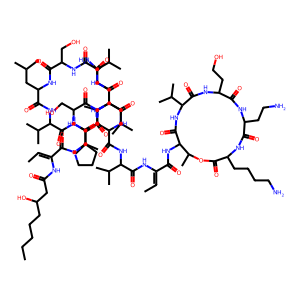

____________________________retival #2, retrival cosine similarity to prediction: 0.7099699378013611_____________________________
SMILES: CCCCCCCCCCCCCCC(=O)NC(CCCN)C(=O)NC(C(=O)NC1C(=O)NC(CCCN)C(=O)NC(CO)C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(CO)C(=O)NC(C(C)CC)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(C(C)CC)C(=O)OC1C)C(C)C
Name Paenibacterin


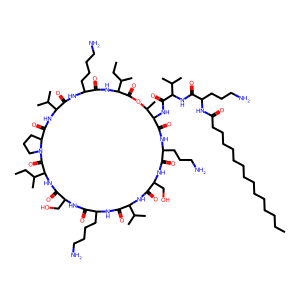

____________________________retival #3, retrival cosine similarity to prediction: 0.7076157331466675_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


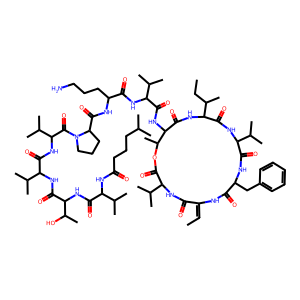

In [ ]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
inputs = build_input(compound_dir)
show_topK(inputs, k=3)




new_compound_B2




_________________________________________________________
cuda:0 cuda:0
____________________________retival #1, retrival cosine similarity to prediction: 0.7942517995834351_____________________________
SMILES: CCC(C)C1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide N


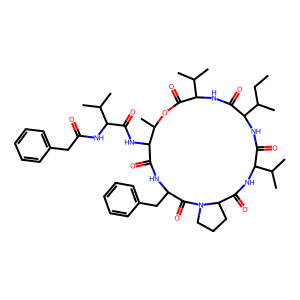

____________________________retival #2, retrival cosine similarity to prediction: 0.7902073860168457_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name xentrivalpeptide D


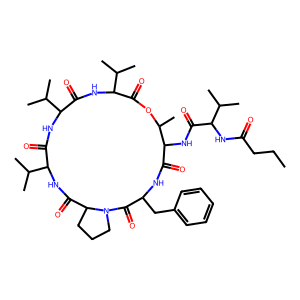

____________________________retival #3, retrival cosine similarity to prediction: 0.7809265851974487_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CC)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide P


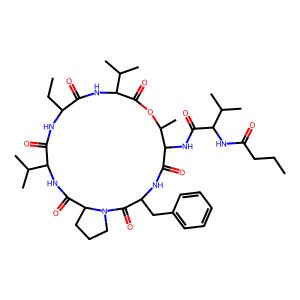

____________________________retival #4, retrival cosine similarity to prediction: 0.7765990495681763_____________________________
SMILES: CC(C)CC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide E


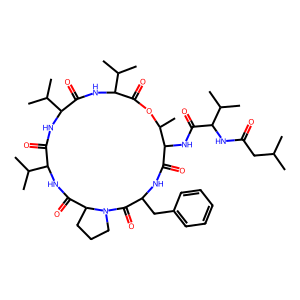

____________________________retival #5, retrival cosine similarity to prediction: 0.7763855457305908_____________________________
SMILES: CCCCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide G


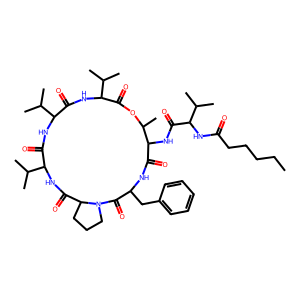

____________________________retival #6, retrival cosine similarity to prediction: 0.7755466103553772_____________________________
SMILES: CCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide C


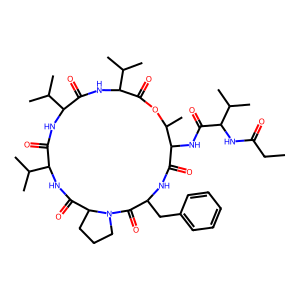

____________________________retival #7, retrival cosine similarity to prediction: 0.7707817554473877_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name 1401343-49-4


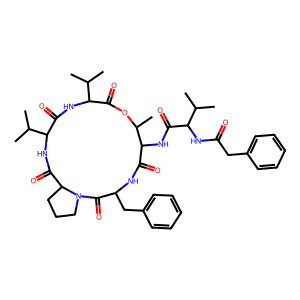

____________________________retival #8, retrival cosine similarity to prediction: 0.7707817554473877_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name xentrivalpeptide A


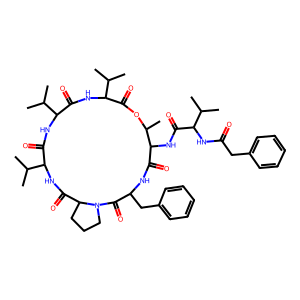

____________________________retival #9, retrival cosine similarity to prediction: 0.7683842778205872_____________________________
SMILES: CCC1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide O


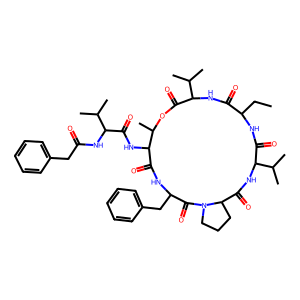

____________________________retival #10, retrival cosine similarity to prediction: 0.7649033069610596_____________________________
SMILES: CC(C)CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide F


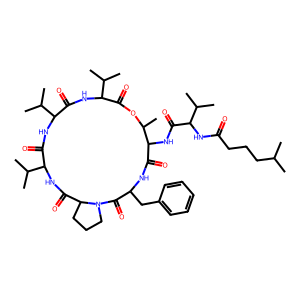

____________________________retival #11, retrival cosine similarity to prediction: 0.7648317217826843_____________________________
SMILES: CC(C)CC1NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C2CCCN2C1=O
Name Xentrivalpeptide L


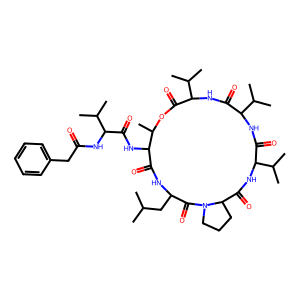

____________________________retival #12, retrival cosine similarity to prediction: 0.7626270055770874_____________________________
SMILES: CCC(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Xentrivalpeptide H


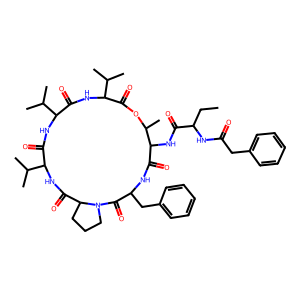

____________________________retival #13, retrival cosine similarity to prediction: 0.7613438963890076_____________________________
SMILES: CCC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Xentrivalpeptide I


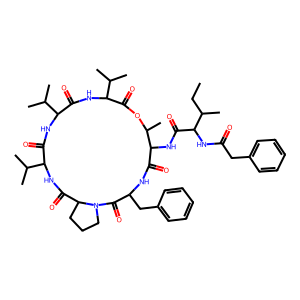

____________________________retival #14, retrival cosine similarity to prediction: 0.7592958211898804_____________________________
SMILES: CC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide B


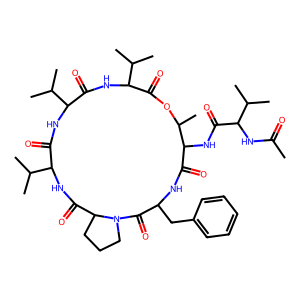

____________________________retival #15, retrival cosine similarity to prediction: 0.7471030950546265_____________________________
SMILES: CCC(C)C1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin D


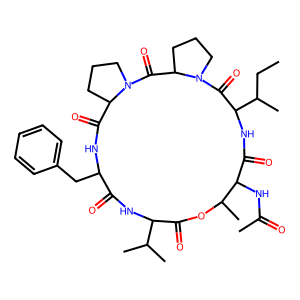

____________________________retival #16, retrival cosine similarity to prediction: 0.7386513948440552_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide J


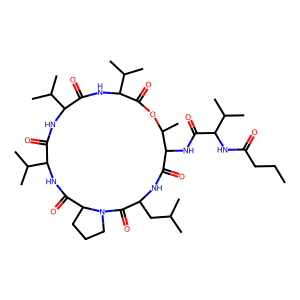

____________________________retival #17, retrival cosine similarity to prediction: 0.7376406192779541_____________________________
SMILES: CCC(C)C1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccccc2)N(C)C(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin C


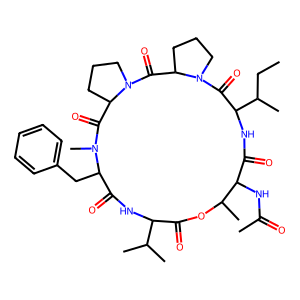

____________________________retival #18, retrival cosine similarity to prediction: 0.7254509329795837_____________________________
SMILES: CC(C)CC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide K


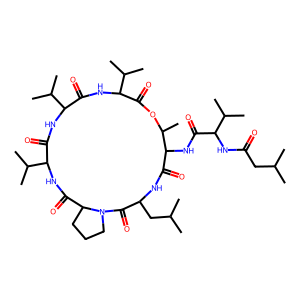

____________________________retival #19, retrival cosine similarity to prediction: 0.720117449760437_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Tasipeptin A


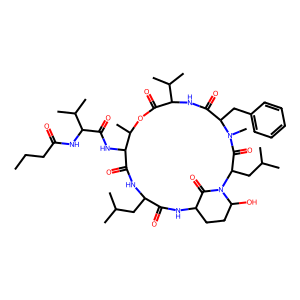

____________________________retival #20, retrival cosine similarity to prediction: 0.7188552021980286_____________________________
SMILES: CCC(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)N2CCCC2C(=O)OC1C
Name Octaminomycin A


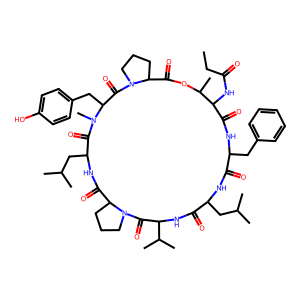

____________________________retival #21, retrival cosine similarity to prediction: 0.7143036127090454_____________________________
SMILES: CCC(C)C1NC(=O)C2CCCN2C(=O)C(C)NC(=O)C2CCCN2C(=O)C(C(C)O)NC(=O)C(Cc2ccccc2)NC(=O)C(C)NC(=O)C(C)NC(=O)C(C(C)C)NC1=O
Name cycloleonuripeptide E


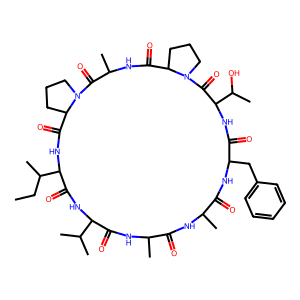

____________________________retival #22, retrival cosine similarity to prediction: 0.7140231728553772_____________________________
SMILES: CC=C1NC(=O)C(NC(=O)C(NC(=O)C(C)NC(=O)CCC)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC1=O
Name lyngbyastatin 9


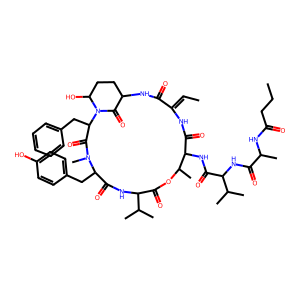

____________________________retival #23, retrival cosine similarity to prediction: 0.7137734889984131_____________________________
SMILES: CC(C)CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide M


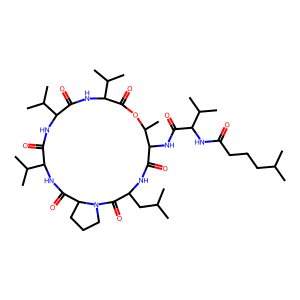

____________________________retival #24, retrival cosine similarity to prediction: 0.7122212648391724_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


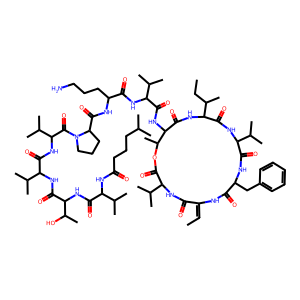

____________________________retival #25, retrival cosine similarity to prediction: 0.7081327438354492_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide F


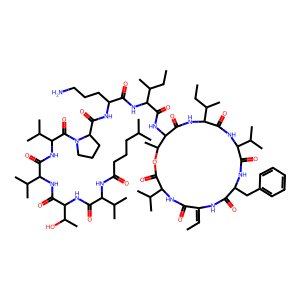

____________________________retival #26, retrival cosine similarity to prediction: 0.7068798542022705_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide U


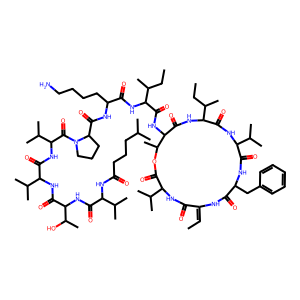

____________________________retival #27, retrival cosine similarity to prediction: 0.705194890499115_____________________________
SMILES: CC(=O)NC1C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(Cc2ccc(O)cc2)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C)C(=O)OC1C
Name FJ120DPA


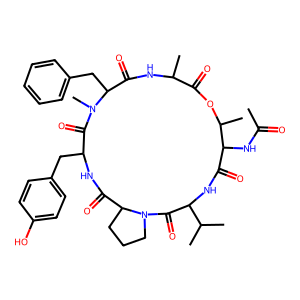

____________________________retival #28, retrival cosine similarity to prediction: 0.7043355107307434_____________________________
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(OC)cc2)NC(=O)C(NC(=O)C(NC=O)C(C)C)C(C)OC(=O)C(C(C)C)N(C)C(=O)C(CC(C)C)NC(=O)C2CCCNN2C1=O
Name marformycin A


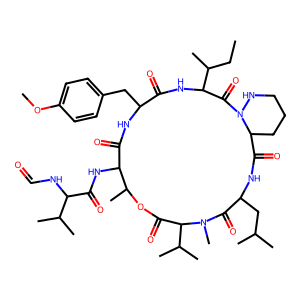

____________________________retival #29, retrival cosine similarity to prediction: 0.7034928798675537_____________________________
SMILES: CC=C1NC(=O)C(NC(=O)C(NC(=O)C(C)NC(=O)CCC)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(O)c(Br)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC1=O
Name lyngbyastatin 10


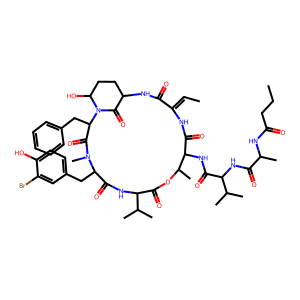

____________________________retival #30, retrival cosine similarity to prediction: 0.7027016878128052_____________________________
SMILES: CC(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)N2CCCC2C(=O)OC1C
Name Octaminomycin B


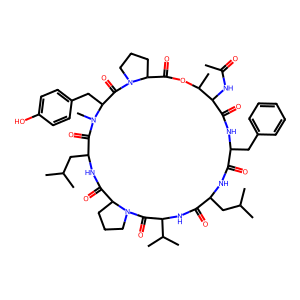

In [ ]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"
inputs = build_input(compound_dir)
show_topK(inputs, k=30)